In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc,roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.datasets import *
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import cross_val_score
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf
from sklearn.utils import shuffle
import random
import gensim
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import graphviz

# Preprocessed and Cleaned Data Saved as Amazon.csv

In [2]:
final_data=pd.read_csv('Amazon.csv')

# Sort the Data Based pn the Time Stamp

In [3]:
final_data.sort_values('Time',ascending=True)
final_data.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


# Spliting the whole Dataset into Train and Test

In [4]:
tscv=TimeSeriesSplit(n_splits=3)
for train_index,test_index in tscv.split(final_data):
    print("Train:", train_index,"Test:", test_index)
    train_data,test_data = final_data.iloc[train_index],final_data.iloc[test_index]

Train: [    0     1     2 ..., 91042 91043 91044] Test: [ 91045  91046  91047 ..., 182084 182085 182086]
Train: [     0      1      2 ..., 182084 182085 182086] Test: [182087 182088 182089 ..., 273126 273127 273128]
Train: [     0      1      2 ..., 273126 273127 273128] Test: [273129 273130 273131 ..., 364168 364169 364170]


In [5]:
#Training data
train_data=shuffle(train_data)
reviews=train_data['Score']
reviews=reviews[0:70000]
train_data=train_data[0:70000]

In [6]:
#Test data
test_data=shuffle(test_data)
test_review=test_data['Score']
test_review=test_review[0:30000]
test_data=test_data[0:30000]

In [7]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'ma', 'be', 'weren', 'our', 'both', "wasn't", 'don', 'and', 'yourself', 'further', 'any', "shan't", 'ourselves', "you've", 'over', 'such', 'after', 'didn', "shouldn't", 'all', 'doesn', 'been', 'is', 'here', 'above', 'haven', "hasn't", "doesn't", 'yours', 'up', 'her', "haven't", 'a', 'which', 'mightn', 'does', 'into', "mustn't", "you'd", "isn't", 'them', 'there', 'most', 'doing', "wouldn't", 'yourselves', 'off', 'just', 't', 'hasn', 'wasn', 'are', "should've", "it's", 'was', 'why', 'to', 'had', 'same', 're', 'down', 'no', 'the', 'i', "couldn't", 'me', 'wouldn', 'herself', 'how', 'he', 'once', 'so', "don't", 'now', 'for', 'few', 'being', 'have', 'ours', "weren't", 'myself', 'has', "aren't", 'those', 'not', 'as', 'while', 'm', 'did', "hadn't", "you'll", 'd', 'can', 'if', 'in', 'against', 'an', 'by', 'this', 'am', 'under', 'himself', 'on', 'or', "mightn't", 'its', 'o', 'between', 'nor', 'it', 'some', 'll', "you're", 'his', 'but', 'own', 'you', "she's", 'having', 'mustn', 'him', 'they', 'u

In [8]:
i=0
list_of_sent_train=[]
for sent in train_data['CleanText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [9]:
i=0
list_of_sent_test=[]
for sent in test_data['CleanText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [10]:
w2v_model_train=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
w2v_model_test=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50,workers=4)

# Converting into Word2vec for Training purpose

In [11]:
sent_vectors_train=[]
for sent in list_of_sent_train:
    sent_vec=np.zeros(50)
    #print(sent_vec)
    cnt_words=0;
    for word in sent:
        try:
            vec=w2v_model_train.wv[word]
            #print(vec)
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))      

70000
50


In [12]:
sent_vectors_test=[]
for sent in list_of_sent_test:
    sent_vec=np.zeros(50)
    #print(sent_vec)
    cnt_words=0;
    for word in sent:
        try:
            vec=w2v_model_test.wv[word]
            #print(vec)
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))      

30000
50


In [13]:
sent_vectors_train_array=np.array(sent_vectors_train)
sent_vectors_train_array=np.nan_to_num(sent_vectors_train_array)

In [14]:
sent_vectors_test_array=np.array(sent_vectors_test)
sent_vectors_test_array=np.nan_to_num(sent_vectors_test_array)

# Finding the optimum depth using cross validation

[0.84925733488426047, 0.85624298395889475, 0.85887146562944672, 0.86044294115043907, 0.86057152484256749, 0.8596001962434443, 0.85764284927959156, 0.85328570229591816, 0.84842859406763882, 0.84434295525043923, 0.83928580416530774, 0.83634293065043885, 0.83277147142915542, 0.82889987138716936, 0.82581420400262218, 0.82391407131836281, 0.82225717945685195, 0.81987139371894968, 0.82018573250962135, 0.81765713655860028, 0.81629993245480925, 0.81585710183002824, 0.81560002632128337, 0.81372859366064176, 0.8151572385720135, 0.8139857752877564, 0.81411432222186664]

The optimal number of depth is 7.


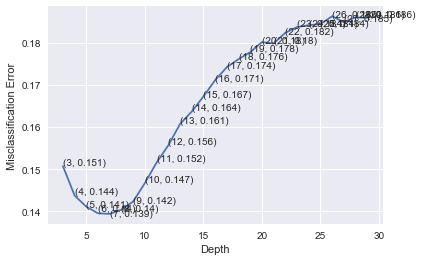

the misclassification error for each i value is :  [ 0.151  0.144  0.141  0.14   0.139  0.14   0.142  0.147  0.152  0.156
  0.161  0.164  0.167  0.171  0.174  0.176  0.178  0.18   0.18   0.182
  0.184  0.184  0.184  0.186  0.185  0.186  0.186]


In [16]:
depth = list(range(3,30))
cv_scores = []

# perform 10-fold cross validation
for i in depth:
    dt = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(dt, sent_vectors_train_array,reviews, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_i = depth[MSE.index(min(MSE))]
print('\nThe optimal number of depth is %d.' % optimal_i)

# plot misclassification error vs depth 
plt.plot(depth, MSE)

for xy in zip(depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each i value is : ", np.round(MSE,3))

In [27]:
tree=DecisionTreeClassifier(max_depth=7)

In [28]:
tree.fit(sent_vectors_train_array,reviews)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Prediction and Evaluation

In [29]:
prediction=tree.predict(sent_vectors_test_array)

In [30]:
print(classification_report(test_review,prediction))

             precision    recall  f1-score   support

          0       0.62      0.06      0.11      4961
          1       0.84      0.99      0.91     25039

avg / total       0.81      0.84      0.78     30000



In [31]:
confu_metric=confusion_matrix(test_review,prediction)
print(confu_metric)

[[  313  4648]
 [  193 24846]]


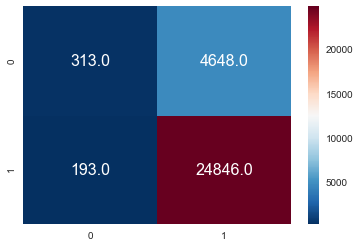

In [32]:
sns.heatmap(confu_metric,annot=True,fmt='.1f',annot_kws={"size": 16},cmap='RdBu_r')

# Test and Train Metric

In [33]:
TP=confu_metric[1][1]
FP=confu_metric[0][1]
TN=confu_metric[0][0]
FN=confu_metric[1][0]

In [34]:
True_positive_rate=TP/(TP+FN) #It tells us when it is actually a Positive Review , How often does it predict Postive Review
print('TPR: ',True_positive_rate)

false_positive_rate=FP/(FP+TN) # It tells us that when the review is negative how often does it predict Positive Review
print('FPR: ',false_positive_rate)

specificity=TN/(TN+FP) #It tells us that When the review is negative ,how often does it predict negative review
print('Specificity: ',specificity)

precision=TP/(TP+FP) # It tells us all the reviews that model has predicted to be Positive how many are truly positive 
print('Precision: ',precision)

recall=TP/(TP+FN) # It tells us that from all the predicted postive reviews how many are actually postive review
print('Recall: ',recall)

f1_score=2*precision*recall/(precision+recall) #It is the weighted average of the Precision and Recall
print('F1Score: ',f1_score)

TPR:  0.992292024442
FPR:  0.936907881476
Specificity:  0.0630921185245
Precision:  0.842408625483
Recall:  0.992292024442
F1Score:  0.911228063741


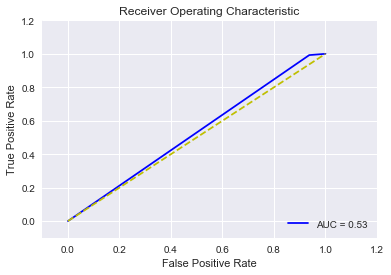

In [35]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(test_review,prediction)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Summary/conclusion

1.I have preprocessed and cleaned  the whole dataset and store in Amazon.csv file for the further use. That CSV contains all the data. 
2. Now We have cleaned data , So I have sorted the Whole data on the basic of the TimeStamp
3. Now I have splitted my whole Dataset into Training,Cross validation and Test datasets for My ML
4. I have taken the 70K sample from the Training purpose and 30K Sample for Testing purpose and another 30K for cross validation
5. Its time to convert our text into vectors . I have used word2vec to convert my text reviews into Vectors . 
   I have converted the Training Sample, Test sample individually

7. First I have used cross validation technique to find the best depth for my decision tree 
8. I have plot the curve between MSE and No. of depth
9. I have applied DecisionTreeClassifier() using best depth. 
10. I have predicted and evaluated the test data using classificationreport and confusion matrix
11. I have also found different test and train metric and on the basic of that I have drawn Roc cuve 

    

# Result comparision Between Word2Vec and Weightted tfidf,BOW and Tfidf

In [1]:
data={'Word2Vec':[0.8424,0.99,0.911,0.53,0.9922,0.9369,0.063],'Weighted tfidf':[0.8312,0.99,0.904,0.51,0.99,0.98,0.01],'Bow':[0.8582,1,0.9237,0.50,1,1,0.0],'Tfidf':[0.8582,1,0.9237,0.50,1,1,0.0]}

In [4]:
pd.DataFrame(data,index=['Precision','Recall','F1Score','ROC','TPR','FPR','Specificty'])

,Bow,Tfidf,Weighted tfidf,Word2Vec
Precision,0.8582,0.8582,0.8312,0.8424
Recall,1.0000,1.0000,0.9900,0.9900
F1Score,0.9237,0.9237,0.9040,0.9110
ROC,0.5000,0.5000,0.5100,0.5300
TPR,1.0000,1.0000,0.9900,0.9922
FPR,1.0000,1.0000,0.9800,0.9369
Specificty,0.0000,0.0000,0.0100,0.0630
